# Base

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
import matplotlib.pyplot as plt 
import numpy as np
import random
import json
import seaborn as sns
from tqdm import tqdm

In [ ]:
DIR_DATA="/content/data/Dataset/" #Path where your dataset (training) files are stored, this folder contains WESADECG_S2.json,WESADECG_S3.json,...WESADECG_Sk.json files
DIR_NET_SAVING="/content/data/Testing/net/" #Path where model's weights are saved for each training
DIR_DATA_TEST="/content/data/Testing/" # Path to your file that contains subject test folder (S17 for my case). eg : DIR_TESTING_FOLDER=/content/data/Testing/
SUBJECT_USED_FOR_TESTING = "S17"

In [ ]:
manualSeed=1
torch.manual_seed(manualSeed)
random.seed(manualSeed)
np.random.seed(manualSeed)
g = torch.Generator()
g.manual_seed(manualSeed)

# Functions

In [3]:
def suppr(dic):
  bornemax=np.quantile(dic["features"],0.99,axis=0)
  bornemin=np.quantile(dic["features"],0.01,axis=0)
  indicesmauvais=np.where(np.sum(np.add(bornemin>np.array(dic["features"]),np.array(dic["features"])>bornemax),axis=1)>0)[0]
  k=0
  for i in indicesmauvais:
    del dic["features"][i-k]
    del dic["label"][i-k]
    k+=1
  return dic

def extract_ds_from_dict(data):
  Letat=[]
  for i in range(0,4):
    dictio={}
    features=[data["features"][j] for j in np.where(np.array(data["label"])==i+1)[0]] 
    label=[data["label"][j] for j in np.where(np.array(data["label"])==i+1)[0]]
    dictio["features"]=features
    dictio["label"]=label
    Letat.append(dictio.copy())
  neutr=Letat[0]
  stress=Letat[1]
  amu=Letat[2]
  med=Letat[3]
  neutr=suppr(neutr)
  stress=suppr(stress)
  amu=suppr(amu)
  med=suppr(med)
  features=[]
  label=[]
  dict_id={}
  for m in range(0,4):
    dictio=Letat[m]
    features+=[x for x in dictio["features"]] 
    label+=[x for x in dictio["label"]]
  dict_id["features"]=features
  dict_id["label"]=label
  return dict_id.copy()   #retourne une liste avec tt

def conf_mat(net,datal,trsh):
  x=datal[0].float().to(device)
  y=net(x).view(-1)
  pred=(y>trsh).int()
  label=datal[1].float().to(device).view(-1).int()
  num=datal[2].float().to(device).int()
  comp=torch.eq(label,pred).int()
  mat_label=np.zeros((2,4))
  mat_nolbl=np.zeros((2,2))
  for i in range(0,4):
    tens=torch.where(num==i+1,1,0)
    numtot=torch.sum(tens).item()
    num_G=torch.sum(torch.where(torch.mul(tens,comp)==1,1,0)).item()
    if i ==1:
      mat_nolbl[0,0]+=num_G
      mat_nolbl[1,0]+=numtot-num_G
      mat_label[0,i]=num_G
      mat_label[1,i]=numtot-num_G
    else:
      mat_nolbl[1,1]+=num_G
      mat_nolbl[0,1]+=numtot-num_G
      mat_label[1,i]=num_G
      mat_label[0,i]=numtot-num_G
  return mat_label,mat_nolbl

def fusion_dic(list_dic):
  features=[]
  label=[]
  dic_f={}
  for dic in list_dic:
    features+=dic["features"]
    label+=dic["label"]
  dic_f["features"]=features
  dic_f["label"]=label
  return dic_f

def proportion(dic, indice, prop):
  tot=len(indice)
  features=[dic["features"][j] for j in indice[::int(np.ceil(tot/prop))]]
  label=[dic["label"][j] for j in indice[::int(np.ceil(tot/prop))]]
  return features,label

def eq_dic(dic):
  indice_neutr=np.where(np.array(dic["label"])==1)[0]
  indice_stress=np.where(np.array(dic["label"])==2)[0]
  indice_amu=np.where(np.array(dic["label"])==3)[0]
  indice_med=np.where(np.array(dic["label"])==4)[0]
  nbr_neutr=len(indice_neutr)
  nbr_stress=len(indice_stress)
  nbr_amu=len(indice_amu)
  nbr_med=len(indice_med)
  prop=min([3*nbr_neutr,nbr_stress,3*nbr_amu,3*nbr_med])
  prop_stress=prop
  prop_neutr=int(0.333*prop)
  prop_amu=int(0.333*prop)
  prop_med=int(0.333*prop)
  features=[]
  label=[]
  dic_f={}
  tempf,templ=proportion(dic,indice_neutr,prop_neutr)
  features+=tempf
  label+=templ
  tempf,templ=proportion(dic,indice_stress,prop_stress)
  features+=tempf
  label+=templ
  tempf,templ=proportion(dic,indice_amu,prop_amu)
  features+=tempf
  label+=templ
  tempf,templ=proportion(dic,indice_med,prop_med)
  features+=tempf
  label+=templ
  dic_f["features"]=features
  dic_f["label"]=label
  return dic_f

# DS creation kfold

In [4]:
class ds_wesad(Dataset):
    def __init__(self, dic):
        self.samples = []
        self.dic=dic
        for i in range(0,len(dic["label"])):
            num=dic["label"][i]
            stress=num==2
            x=np.array(dic["features"][i])
            self.samples.append((x,int(stress),num))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, id):
        return self.samples[id]

In [10]:
"""Handles the cross validation process, generates the multiple training and validation data dictionnaries for the cross validation"""


name_list= ['WESADECG_S2.json', 'WESADECG_S3.json', 'WESADECG_S4.json', 'WESADECG_S5.json', 'WESADECG_S6.json', 'WESADECG_S7.json',
 'WESADECG_S8.json', 'WESADECG_S9.json', 'WESADECG_S10.json', 'WESADECG_S11.json', 'WESADECG_S13.json', 'WESADECG_S14.json',
 'WESADECG_S15.json', 'WESADECG_S16.json']

#assert (len(name_list)==14)  ONE Subject for testing S17
list_dic_ds=[]
cntr=0

L=[]
for i in range(0,len(name_list)):
    f=open(DIR_DATA+name_list[i])
    data = json.load(f)
    dic=eq_dic(data)
    L.append(dic)
dic_merge = fusion_dic(L)
dic_training=extract_ds_from_dict(dic_merge)
ds_training=ds_wesad(dic_training)

In [13]:
os.chdir("/content/data/Testing")
name= 'WESADECG_{}.json'.format(SUBJECT_USED_FOR_TESTING)
f=open(DIR_DATA_TEST+name)
data = json.load(f)
ds_test = ds_wesad(data)

# Model

In [17]:
from torch.nn.modules.activation import LeakyReLU
""" DNN Model """

def init_weight(m):
    """Initialization of the weights"""
    if isinstance(m,nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)
    if isinstance(m, nn.BatchNorm1d):
        m.weight.data.fill_(1)
        m.bias.data.zero_() 

class ClassifierECG(nn.Module):
    """DNN model, see the model architecture in the report for more details"""
    def __init__(self, ngpu):
        super(ClassifierECG, self).__init__()
        self.ngpu = ngpu
        self.nnECG = nn.Sequential(
            nn.Linear(12,128,bias=True),
            nn.BatchNorm1d(128),
            nn.Dropout(0.5),
            nn.LeakyReLU(0.2),
            nn.Linear(128,64,bias=True),
            nn.BatchNorm1d(64),
            nn.Dropout(0.5),
            nn.LeakyReLU(0.2),
            nn.Linear(64,16,bias=True),
            nn.BatchNorm1d(16),
            nn.Dropout(0.5),
            nn.LeakyReLU(0.2),
            nn.Linear(16,4,bias=True),
            nn.BatchNorm1d(4),
            nn.Dropout(0.5),
            nn.LeakyReLU(0.2),
            nn.Linear(4,1,bias=True),
            nn.Sigmoid()
        )
        self.nnECG.apply(init_weight)

    def forward(self, input):
        return self.nnECG(input)

# Training

In [19]:
def training(net,dataloader_t,dataloader_v,num_epochs,j,k):
  """ Training with a BCELoss on the dataset, for each epoch the net weights are saved and the mean error is computed to plot the loss
  for training and valdiation dataset
  """
  Loss = []
  Lossv= []
  for epoch in range(num_epochs):
      L_t=[]
      L_v=[]
      for i, dataj in enumerate(dataloader_t, 0):
          net.zero_grad()
          x=dataj[0].float().to(device)
          yhat=dataj[1].float().to(device)
          yhat=yhat.view(-1,1)
          y=net(x)
          err_t=nn.BCELoss()(y.float(),yhat.float())
          err_t.backward()
          optimizer.step()
          L_t.append(err_t.item())
      for i, dataj in enumerate(dataloader_v, 0):
        net.eval()     
        x=dataj[0].float().to(device)
        yhat=dataj[1].float().to(device)
        yhat=yhat.view(-1,1)
        y=net(x)
        err_v=nn.BCELoss()(y.float(),yhat.float())
        L_v.append(err_v.item())
      err=np.mean(L_t)
      errv=np.mean(L_v)
      Loss.append(err)
      Lossv.append(errv)
      torch.save(net.state_dict(), DIR_NET_SAVING+"net_"+str(j)+"_"+str(k)+"_epoch_"+str(epoch)+".pth")
  return [Lossv,np.argmin(Lossv)]

In [18]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

num_workers = 2
batch_size = 32
ngpu = 1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu") 

In [ ]:
net= ClassifierECG(ngpu).to("cuda")
lr=0.0001
beta1=0.9
optimizer = optim.Adam(net.parameters(), lr=lr, betas=(beta1, 0.999))
dataloader_t = torch.utils.data.DataLoader(ds_training,batch_size=batch_size,shuffle=True,num_workers=num_workers,worker_init_fn=seed_worker,generator=g, drop_last=True)
dataloader_test = torch.utils.data.DataLoader(ds_test,batch_size=batch_size,shuffle=True,num_workers=num_workers,worker_init_fn=seed_worker,generator=g, drop_last=True)
Lossv,argmin=training(net,dataloader_t,dataloader_test,10,0,0)

# Results

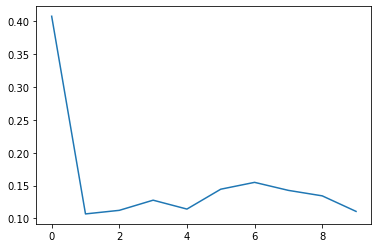

In [24]:
plt.plot(Lossv)

In [25]:
net.load_state_dict(torch.load(DIR_NET_SAVING+"net_0_0_epoch_{}.pth".format(argmin)))

<All keys matched successfully>

accuracy 0.9614583333333333
precision 0.8617683686176837
recall 1.0
F1score 0.925752508361204


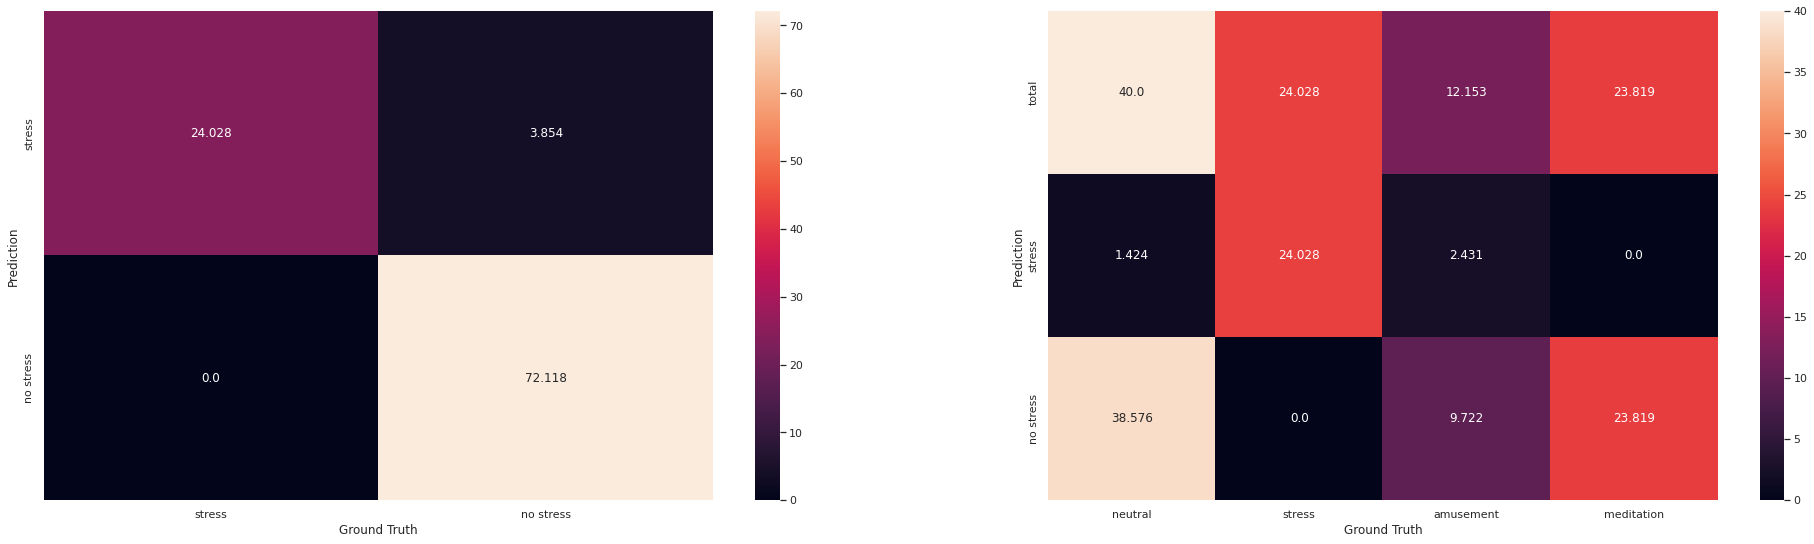

In [56]:
# Results
Loss = []
trsh=0.5
net.eval()
confusionlabel=np.zeros((2,4))
confusion=np.zeros((2,2))
length_ds=0
for i, datal in enumerate(dataloader_test, 0):
      confusionlabelt,confusiont=conf_mat(datal,trsh)
      confusion+=confusiont
      confusionlabel+=confusionlabelt
      length_ds+=batch_size
x_axis_confl = ['neutral','stress','amusement','meditation'] # labels for x-axis
y_axis_confl = ['stress','no stress'] # labels for y-axis
x_axis_conf = ['stress','no stress']
y_axis_conf = ['stress','no stress']

# create seabvorn heatmap with required labels
confusion_annot=np.array([str(x) for x in np.round(100*confusion/length_ds,3).reshape(-1).tolist()]).reshape(confusion.shape)
confusionlabel_annot=np.array([str(x) for x in np.round(100*confusionlabel/length_ds,3).reshape(-1).tolist()]).reshape(confusionlabel.shape)
sns.set(rc={"figure.figsize":(15, 5)})
fig, axs = plt.subplots(ncols=2,figsize=(33,9))
sns.heatmap((100*confusion/length_ds), xticklabels=x_axis_conf, yticklabels=y_axis_conf,annot=confusion_annot,ax=axs[0],fmt = '')
axs[0].set_xlabel('Ground Truth')
axs[0].set_ylabel('Prediction')
sns.heatmap((100*confusionlabel/length_ds), xticklabels=x_axis_confl, yticklabels=y_axis_confl, annot=confusionlabel_annot,ax=axs[1],fmt = '')
axs[1].set_xlabel('Ground Truth')
axs[1].set_ylabel('Prediction')
TP=confusion[0,0]
TN=confusion[1,1]
FN=confusion[1,0]
FP=confusion[0,1]
acc=(TP+TN)/(TP+FP+FN+TN)
precision=TP/(TP+FP)
recall=TP/(TP+FN)
F1score=(2*recall*precision)/(recall+precision)
print("accuracy " +str(acc))
print("precision " +str(precision))
print("recall " +str(recall))
print("F1score "+str(F1score))